In [39]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def construct_rescaled_hamiltonian_pbc(N, M, V, mu_V_ratio, J_V_ratio, use_periodic_bc = False):
# to write

    mu = mu_V_ratio * abs(V)
    J = J_V_ratio * abs(V)
    dim = M**N
    H = np.zeros((dim, dim), dtype=np.complex128)

    # Precompute powers of M for faster state-to-index conversion
    M_powers = np.array([M**i for i in range(N)])

    # Helper function to convert a state index to a state representation (array of states)
    def index_to_state(index):
        return np.array([(index // M_powers[i]) % M for i in range(N-1, -1, -1)])
    
    # Helper function to convert a state representation (array of states) back to an index
    def state_to_index(state):
        return np.dot(state, M_powers[::-1])

    # Apply the chemical potential term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            if state[j] == 0:
                H[alpha, alpha] -= mu

    # Apply the tunneling term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for j in range(N):
            for n in range(1, M):
                if state[j] == n:
                    new_state = state.copy()
                    new_state[j] = n - 1
                    beta = state_to_index(new_state)
                    H[alpha, beta] -= J
                    H[beta, alpha] -= J  # Ensure Hermitian symmetry

    # Apply the interaction term
    for alpha in range(dim):
        state = index_to_state(alpha)
        for i in range(N - 1):
            j = i + 1
            for n in range(1, M):
                if state[i] == n and state[j] == n - 1:
                    new_state = state.copy()
                    new_state[i], new_state[j] = n - 1, n
                    beta = state_to_index(new_state)
                    H[alpha, beta] += V
                    H[beta, alpha] += V  # Ensure Hermitian symmetry
                    
    # Rescale H to H_tilde by dividing by |V|
    H_tilde = H / abs(V)
    
    return H_tilde

In [41]:
N = 4
M = 3
mu_V_ratio = 0
J_V_ratio = 1
V = 1

pbc_H = construct_rescaled_hamiltonian_PBC(N,M,V,mu_V_ratio,J_V_ratio)
obc_H = construct_rescaled_hamiltonian(N,M,V,mu_V_ratio,J_V_ratio)

In [42]:
J_V_ratios = np.linspace(-2,2,100)
pbc_energies = []
obc_energies = []
for J_V_ratio in J_V_ratios:
    pbc_H = construct_rescaled_hamiltonian_PBC(N,M,V,mu_V_ratio,J_V_ratio)
    obc_H = construct_rescaled_hamiltonian(N,M,V,mu_V_ratio,J_V_ratio)
    pbc_eigenvals, pbc_eigenvectors = exact_diagonalize(pbc_H)
    obc_eigenvals, obc_eigenvectors = exact_diagonalize(obc_H)
    pbc_energies.append(pbc_eigenvals)
    obc_energies.append(obc_eigenvals)

pbc_energies = np.array(pbc_energies)
obc_energies = np.array(obc_energies)

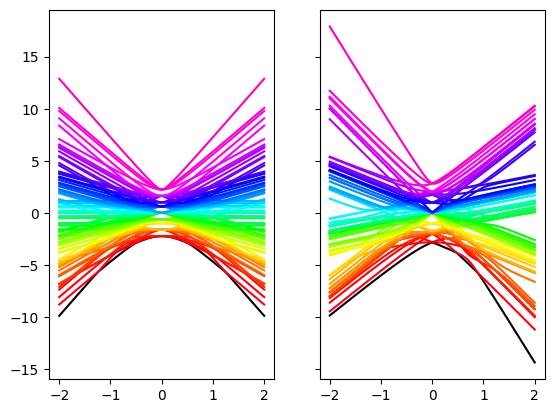

In [43]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, sharey=True)
colors = get_cmap("gist_rainbow", M**N)
for idx in range(M**N):
    if idx == 0:
        ax1.plot(J_V_ratios, obc_energies[:,idx], color = "k")
        ax2.plot(J_V_ratios, pbc_energies[:,idx], color = "k")
    else:
        
        ax1.plot(J_V_ratios, obc_energies[:,idx], color = colors(idx))
        ax2.plot(J_V_ratios, pbc_energies[:,idx], color = colors(idx))